In [1]:
import pandas as pd
import os

import tensorflow as tf
import json
import numpy as np
import pandas as pd
import cv2
from skimage import exposure

import matplotlib.pyplot as plt
import seaborn as sns

from cell_division.nets.transfer_learning import CNN
from auxiliary.data.dataset_cell import CellDataset
from auxiliary import values as v
from auxiliary.utils.colors import bcolors as c
from auxiliary.utils import visualizer as vis
from auxiliary.data import imaging

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import GlobalAveragePooling2D
from cell_division.nets.custom_layers import (
    w_cel_loss, 
    focal_loss,
    ExtendedLSEPooling,
    extended_w_cel_loss,
    LSEPooling
)


from cell_division.nets.cam import GradCAM, overlay_heatmap, CAM, GradCAMpp

# GPU config
from auxiliary.utils.timer import LoadingBar
from auxiliary.data.dataset_unlabeled import UnlabeledDataset
from auxiliary.data.dataset_ht import HtDataset

In [2]:
# specimens = [item for sublist in v.specimens.values() for item in sublist]
# specimens = np.random.choice(specimens, 10)
specimens = ['0808_E5', '0503_E1', '0308_E3', '0806_E6', '0518_E3', '', '', '', '', '', '']

ht_ds = HtDataset() 

for specimen in specimens:    
    print(f'{c.OKBLUE}Processing specimen:{c.ENDC} {specimen}')

    try:
        # Check if the specimen has the required files
        p_img_raw_mem, _ = ht_ds.read_specimen(specimen, level='Membrane', type='RawImages')
        p_img_raw, _ = ht_ds.read_specimen(specimen, level='Nuclei', type='RawImages')
        p_img_seg, _ = ht_ds.read_specimen(specimen, level='Nuclei', type='Segmentation')
        features = ht_ds.get_features(specimen, type='Nuclei')

        # Read the images
        img_raw_mem = imaging.read_image(p_img_raw_mem, verbose=1).astype(np.uint8)
        img_raw = imaging.read_image(p_img_raw, verbose=1).astype(np.uint8)
        img_seg = imaging.read_image(p_img_seg, verbose=1)

        # Get the features
        labels, centroids = features['original_labels'], features['centroids']

        count = 0
        for i, label in enumerate(labels):
            # Get the centroids of the cell
            cen = centroids[i].replace('[', '').replace(']', '').split(',')
            x, y, z = int(cen[0]), int(cen[1]), int(cen[2])
        
            # Crop the cell region + Erode the mask
            mask = img_seg[x-25: x+25, y-25: y+25, z-10: z+10]
            mask = np.where(mask == label, 255, 0).astype(np.uint8)
            mask = np.swapaxes(np.swapaxes([
                cv2.erode(mask[..., z], np.ones((1, 1)), iterations=1) 
                for z in range(mask.shape[2])
            ], 0, 1), 1, 2)
            
            # Remove empty z-slices
            non_empty_slices = [i for i in range(mask.shape[2]) if np.any(mask[..., i])]
            mask = mask[..., non_empty_slices]
        
            # Crop the cell region of the raw image
            img_cell = img_raw[x-25: x+25, y-25: y+25, z-10: z+10]
            img_cell = img_cell[..., non_empty_slices]

            img_mem = img_raw_mem[x-25: x+25, y-25: y+25, z-10: z+10]
            img_mem = img_mem[..., non_empty_slices]
        
            # Erase the background
            img_cell_no_bg = np.where(mask == 0, 0, img_cell)
            
            # IQR Filter over the intensities of the cell
            img_cell_no_bg, intensities, thresh = imaging.iqr_filter(img_cell_no_bg, get_params=True, verbose=0)

            img_cell = img_cell[..., intensities > thresh]
            img_mem = img_mem[..., intensities > thresh]

            # Merge the images as an 3D RGB image (img_cell and img_mem)
            img_all = np.stack([img_cell, img_mem, np.zeros_like(img_cell)], axis=-1)
        
            # Save the images
            img_cell_no_bg = img_cell_no_bg.astype(np.uint8)
            if img_cell_no_bg.shape[2] > 0:
                count += 1
                imaging.save_prediction(
                    img_cell_no_bg,
                    v.data_path + 'CellDivision/images_unlabeled/' + f'{specimen}_{int(label)}.tif',
                    verbose=0
                )
                imaging.save_prediction(
                    img_all,
                    v.data_path + 'CellDivision/images_unlabeled_bg/' + f'{specimen}_{int(label)}.tif',
                    verbose=0
                )
        count = 0
        print(f'\t{c.BOLD}Saved {count} cells{c.ENDC}')

    except Exception as e:
        print(f'{c.FAIL}Error:{c.ENDC} {e}')
        continue


Processing specimen: 0806_E5
Error: No specimen found: 0806_E5
Processing specimen: 0504_E1
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/RawImages/Nuclei/20190504_E1_DAPI_decon_0.5.nii.gz
Reading TIFF: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/Segmentation/Nuclei/20190504_E1_Fernando.tif
	Saved 0 cells
Processing specimen: 0208_E2
Error: No specimen found: 0208_E2
Processing specimen: 0521_E4
Error: No specimen found: 0521_E4
Processing specimen: 0521_E2
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/RawImages/Nuclei/20190521_E2_DAPI_decon_0.5.nii.gz
Reading TIFF: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/Segmentation/Nuclei/20190521_E2_Fernando.tif
	Saved 0 cells
Processing specimen: 0516_E2
Error: No specimen found: 0516_E2
Processing specimen: 0503_E1
Error: No specimen found: 0503_E1
Processing 

Histogram of intensities

In [12]:
def plot_global_intensity_hist(stacks, bins=100):
    all_intensities = []
    for i, stack in enumerate(stacks):
        stack = stack * 255
        stack = stack.astype(np.uint8)
        all_intensities.append(np.mean(stack.flatten()))
    
    plt.figure(figsize=(10, 5))
    sns.histplot(
        all_intensities, kde=True, bins=bins, 
        color='blue', alpha=0.7
    )
    plt.title('Histogram of intensities')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.show()

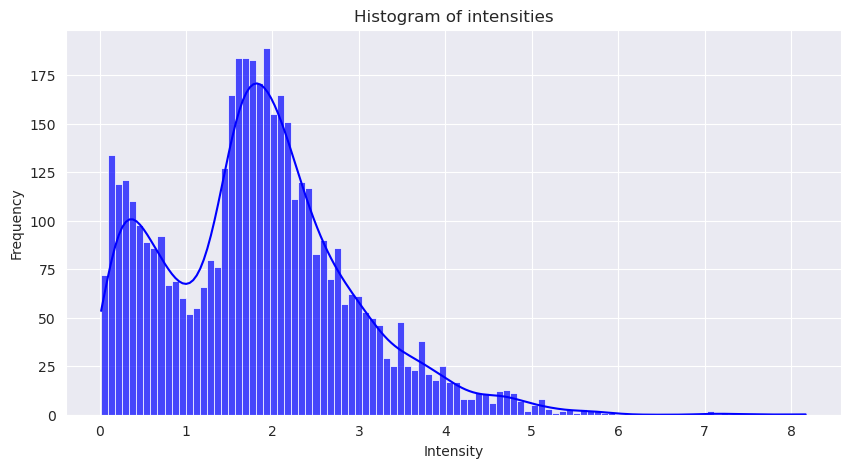

In [13]:
from auxiliary.data.dataset_unlabeled import UnlabeledDataset


data_path = v.data_path + 'CellDivision/images_unlabeled/'
unlabeled_ds = UnlabeledDataset(data_path, batch_size=1)

plot_global_intensity_hist(unlabeled_ds)

Filter the images based on the intensity

In [3]:
data_path = v.data_path + 'CellDivision/images_unlabeled/'
unlabeled_ds = UnlabeledDataset(data_path, batch_size=1)

In [4]:
def filter_intensity(stacks, threshold=0.3):
    removed = 0
    
    for i, (stack, path) in enumerate(stacks):
        stack = stack * 255
        stack = stack.astype(np.uint8)
        if np.mean(stack.flatten()) < threshold:
            os.remove(path[0])
            removed += 1
            
    print(f'Removed {removed} images')
    
filter_intensity(unlabeled_ds)

Removed 1683 images
